In [1]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure
import scipy.stats as stats
import pylab
from itertools import permutations
#!pip install ipython-autotime

In [3]:
#Upload Data and Define Parameters
gly_aa = open('/Users/radakovic/Library/CloudStorage/OneDrive-DepartmentofMolecularBiology-MGH/Szostak lab/Szostak Lab/RNA-Peptide Conjugates/Sequencing/Fastq/CP 1.6/Rep2/Hydro-gly_S4_L001_R1_001.fastq').readlines()

ctrl = open('/Users/radakovic/Library/CloudStorage/OneDrive-DepartmentofMolecularBiology-MGH/Szostak lab/Szostak Lab/RNA-Peptide Conjugates/Sequencing/Fastq/CP 1.6/Rep2/Drop-ctrl_S2_L001_R1_001.fastq').readlines()

In [4]:
#Upload Data and Define Parameters
file_type = '.fastq'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9

#construct 11a
#Position motif1 starts at
motif_start = 1
#Motif1 define
motif = 'CATCGGACC'
#Position motif2 starts at
motif2_start = 16
#Motif2 define
motif2 = 'AGATCGGAAGAGCACACGTCT'
#ctrl motif 2 starts at
ctrlmotif2_start = 16
#ctrlmotif2 define
ctrlmotif2 = 'AGATCGGAAGAGCACACGTCT'

In [5]:
#functions for the initial processing of sequences

def preprocess_seqs(list_of_seqs):

    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('High quality seqs: '+str(len(high_quality)))
        
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n')) #reverse_complement is imported from one of the packages above
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs with constant region
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if motif2 in seq:
                trimmed.append(seq[(motif_start-1)+len(motif):(motif2_start-1)]) #the -1 accounts for indexing starting at 0 in python. dont mess with this
    print('Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_seqs = trimmed
    #Unique seqs
    processed_seqs_unique = list(set(trimmed))
    
    return processed_seqs, processed_seqs_unique


def preprocess_ctrl_seqs(list_of_seqs):
        
    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Ctrl Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('Ctrl High quality seqs: '+str(len(high_quality)))
        
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n')) #reverse_complement is imported from one of the packages above
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs with constant region
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if ctrlmotif2 in seq:
                trimmed.append(seq[(motif_start-1)+len(motif):(motif2_start-1)]) #the -1 accounts for indexing starting at 0 in python. dont mess with this
    print('Ctrl Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_ctrl_seqs = trimmed
    #Unique seqs
    processed_ctrl_seqs_unique = list(set(trimmed))
    
    return processed_ctrl_seqs, processed_ctrl_seqs_unique



In [6]:
#amino acid sequences processed
gly_processed_seqs, gly_processed_seqs_unique = preprocess_seqs(gly_aa)
gly_top_seqs = Counter(gly_processed_seqs).most_common(4096)
print('Unique AA seqs '+str(len(gly_processed_seqs_unique)))
print(gly_top_seqs[:10])

Total seqs: 1561120
High quality seqs: 1426381
Seqs after trimming: 171407
Unique AA seqs 4083
[('AGATCG', 15259), ('CAGATC', 538), ('GTAAGA', 535), ('GTAGAT', 432), ('TAGATC', 381), ('GTTCTA', 369), ('TCTACA', 345), ('GTGTAA', 324), ('AAGATC', 298), ('GTTAGA', 293)]


In [10]:
#control sequences processed
ctrl_processed_ctrl_seqs, ctrl_processed_ctrl_seqs_unique = preprocess_ctrl_seqs(ctrl)
ctrl_top_seqs = Counter(ctrl_processed_ctrl_seqs).most_common(4096)
print('Unique control seqs '+str(len(ctrl_processed_ctrl_seqs_unique)))
print(ctrl_top_seqs[:10])

Ctrl Total seqs: 2701385
Ctrl High quality seqs: 2459878
Ctrl Seqs after trimming: 337956
Unique control seqs 4096
[('AGATCG', 39307), ('GTTCTA', 2366), ('TCTACA', 2310), ('TAGATC', 1611), ('CTACAG', 1533), ('ACAGTC', 1469), ('CAGAGT', 1190), ('CAGATC', 1106), ('TACAGT', 978), ('AGAGTT', 848)]


In [11]:
#normalization of amino acid sequences
ctrl_top_seqs_dict = dict(ctrl_top_seqs)
ctrl_top_seqs_dict = {k: v / 82.5 for k, v in ctrl_top_seqs_dict.items() if v > 15}
gly_top_seqs_dict = dict(gly_top_seqs)

normalized_gly_seqs = {key: gly_top_seqs_dict[key] // ctrl_top_seqs_dict.get(key, 0) if ctrl_top_seqs_dict.get(key,0) != 0 else 0
                        for key in gly_top_seqs_dict.keys()}

sorted_normalized_gly_seqs = sorted(normalized_gly_seqs.items(), key=lambda item: item[1])[::-1]
print(sorted_normalized_gly_seqs[:10])

import pandas as pd
df = pd.DataFrame(sorted_normalized_gly_seqs, columns =['Sequence', 'Normalized counts'])
df.to_excel(r'/Users/radakovic/Library/CloudStorage/OneDrive-DepartmentofMolecularBiology-MGH/Szostak lab/Szostak Lab/RNA-Peptide Conjugates/Sequencing/Fastq/Code/CP1-6_6nt_Hydro.xlsx', index = False)

[('ATTTTG', 357.0), ('ATTTCG', 305.0), ('GTGTAA', 303.0), ('ATTTTC', 265.0), ('CTATTG', 262.0), ('TACATT', 258.0), ('ATTATA', 249.0), ('CGTGCG', 241.0), ('ATTTAT', 241.0), ('CGTACG', 240.0)]


<Figure size 432x288 with 0 Axes>

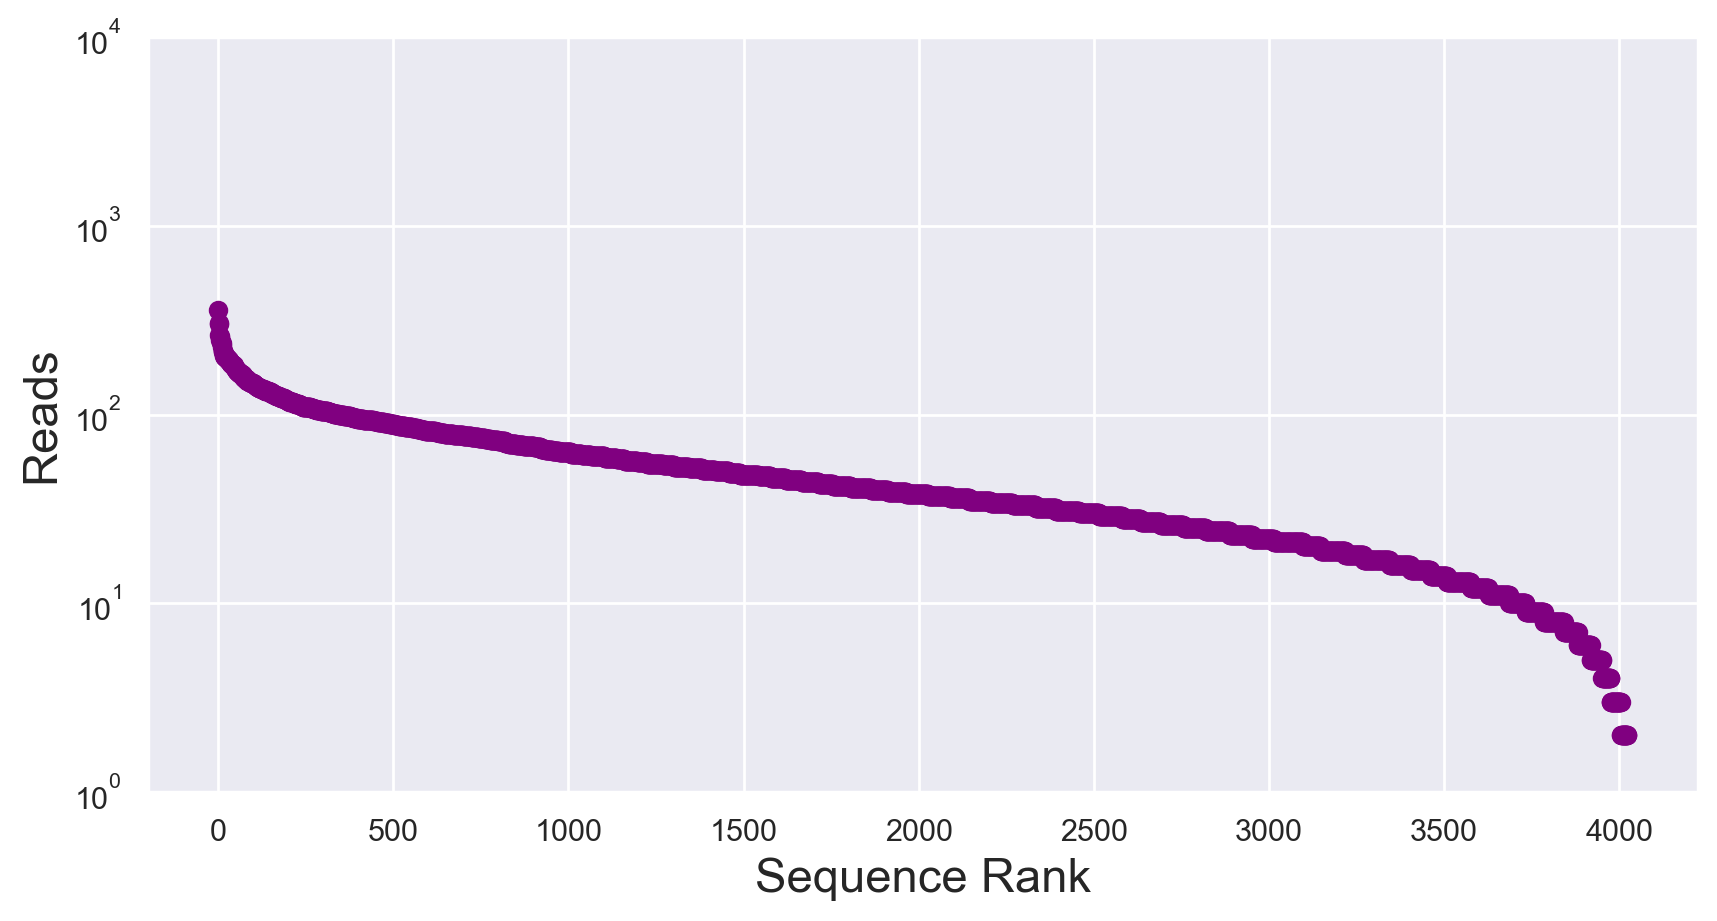

In [9]:
#Sutherland distribution plot all seqs with >1 reads
plt.figure(facecolor="white")
figure(figsize=(10, 5), dpi=200)
ordered_counts_aa = sorted(dict(Counter(normalized_gly_seqs)).values(), reverse=True)
plt.scatter(range(1,len([i for i in ordered_counts_aa if i > 1])+1), [i for i in ordered_counts_aa if i > 1], color = 'purple', label = 'All AA Sequences')
plt.xlabel('Sequence Rank', fontsize = 17)
plt.ylabel('Reads', fontsize = 17)
plt.yscale('log')
plt.ylim([1, 10000])
plt.savefig('/Users/radakovic/Library/CloudStorage/OneDrive-DepartmentofMolecularBiology-MGH/Szostak lab/Szostak Lab/RNA-Peptide Conjugates/Sequencing/Fastq/Code/6nt_Hydro.png', bbox_inches='tight')



In [11]:
#heatmap function
def make_heatmap(seqs_to_analyze):
  heatmap_data = []

  for position in range(len(seqs_to_analyze[0])):
      options = []
      for seq in seqs_to_analyze:
          options.append(seq[position])
      raw_options = [(k, v) for k, v in Counter(options).items()]
      nuc_list = []
      for element in raw_options:
          nuc_list.append(element[0])
      if 'A' not in nuc_list:
            raw_options.append(('A', 0))
      if 'C' not in nuc_list:
            raw_options.append(('C', 0))
      if 'G' not in nuc_list:
            raw_options.append(('G', 0))
      if 'T' not in nuc_list:
            raw_options.append(('T', 0))    
      raw_options = sorted(raw_options, key=lambda x: x[0])        
      
      heatmap_data_position = []
      for element in raw_options:
          heatmap_data_position.append(element[1]/len(seqs_to_analyze))
      heatmap_data.append(heatmap_data_position)


  fig, ax = plt.subplots(figsize = (30,6));
  im = ax.imshow(np.array(heatmap_data).transpose(), interpolation='nearest', cmap='YlOrRd');
  im.set_clim(0,1)
  cbar = fig.colorbar(im, orientation='vertical',)
  y_label_list = ['', 'A', 'C', 'G', 'T', ''];
  ax.set_yticks(range(-1, 1+len(heatmap_data[0])));
  ax.set_yticklabels(y_label_list);
  ax.set_xticks(range(len(heatmap_data)));
  ax.set_xticklabels(range(1, len(heatmap_data)+1));
  ax.grid(False)
  plt.show()
  return heatmap_data

/var/folders/fd/xmvsn53x16353qb6dzc1zzrh0000gp/T/ipykernel_21476/1350435216.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  im = ax.imshow(np.array(heatmap_data).transpose(), interpolation='nearest', cmap='YlOrRd');


TypeError: Image data of dtype object cannot be converted to float

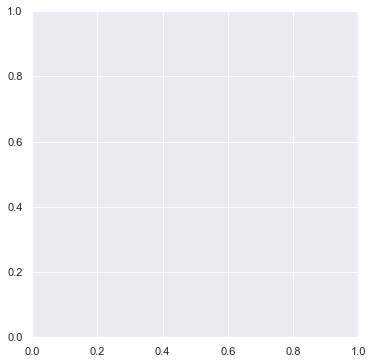

In [12]:
#Find prevalence of sequences in control
#ctrl prevalence
motif_ctrl_1 = 'TTCAGGACC'
len_half_1 = 5
half_1 = []
for seq in ctrl[1::4]:
    if motif_ctrl_1 in seq:
        sub = seq[seq.index(motif_ctrl_1)+len(motif_ctrl_1):seq.index(motif_ctrl_1)+len(motif_ctrl_1)+len_half_1]
        if len(sub) == 5:
            half_1.append(sub)

make_heatmap(half_1)